# R ensemble generalized additive model (EGAM) example
## Developed by
## John Hogland 5/17/2021
### Contact john.s.hogland@usda.gov
### Required libraries, mgcv, raster, rgdal, rgeos, gstat, snow

This is a working example of the EGAM procedures described in (Hogland et. al. 2018, and Hogland et. al. 2019). These procedures can be broken down into 3 main components: 1) a variable selection routine, 2) a EGAM creation routine, and 3) a raster creation component. To illustrate this routine we will be creating a raster dataset with spatial correlation and predefined error. Let's get started!

---

Hogland, J.; Anderson, N.; St. Peter, J; Drake, J.; Medley, P. 2018. Mapping forest characteristics at fine resolution across large landscapes of the southeastern United States using NAIP imagery and FIA field plot data, *International journal of Geo-Information*, 7(4): 140. https://www.mdpi.com/2220-9964/7/4/140 

Hogland, J.; Affleck, D.L.; Anderson, N.; Seielstad, C.; Dobrowski, S.; Graham, J.; Smith, R. 2020. Estimating forest characteristics for longleaf pine restoration using normalized remotely sensed imagery in Florida, USA. *Forests*, 11, 426. https://www.mdpi.com/1999-4907/11/4/426



# Install required packages and load libraries

In [1]:

install.packages(c("rgdal","raster","rgeos","gstat","snow"))

library(rgdal)
library(raster)
library(rgeos)
library(gstat)
library(mgcv)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘intervals’, ‘sp’, ‘terra’, ‘zoo’, ‘spacetime’, ‘FNN’


Loading required package: sp

Please note that rgdal will be retired by the end of 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.

rgdal: version: 1.5-28, (SVN revision 1158)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
Path to GDAL shared files: /usr/share/gdal/2.2
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
Path to PROJ shared files: (autodetected)
Linking to sp version:1.4-6

rgeos version: 0.5-9, (SVN revision 684)
 GEOS runtime version: 3.6.2-CAPI-1.10.2 
 Please note that rgeos will be retired by the end of 2023,
plan transition to sf functions using GEOS at your earliest convenience.
 Linking to sp version: 1.4-6 


# Create a raster dataset with spatial autocorrelation. This surface is made up but for this example it can be thought of as a basal area per acre (BAA; ft squared). 


1.   Define a new raster size 200 * 200
2.   Define the gstat object range, sill, mean
3.   Create the gstat model with spherical correlation
4.   Use the model to predict raster values
5.   Convert grid to a raster object
6.   Plot the raster object




[using unconditional Gaussian simulation]
class      : RasterLayer 
dimensions : 200, 200, 40000  (nrow, ncol, ncell)
resolution : 1, 1  (x, y)
extent     : 0.5, 200.5, 0.5, 200.5  (xmin, xmax, ymin, ymax)
crs        : NA 
source     : memory
names      : sim1 
values     : 95.69155, 209.4178  (min, max)



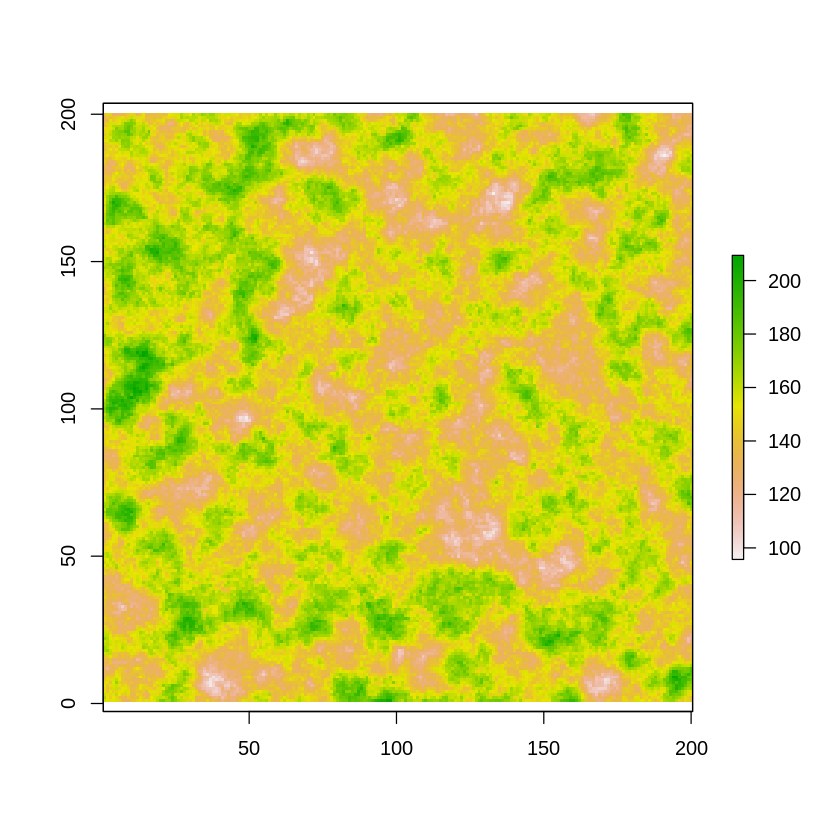

In [2]:
# 1. Define a new raster size 200 *200
clm<-200
n<-clm*clm
xy <- expand.grid(1:clm, 1:clm) #create a grid of x and y locations
names(xy) <- c("x","y") #name the columns

# 2. define the gstat object range,sill, mean
rngVl<-15 # range value for correlogram
vr<-250 #variance parameter (sill)
mn<-150 #mean value

# 3. Create the gstat model  wiht spherical correlation
g.dummy <- gstat(formula=z~1, locations=~x+y, dummy=T, beta=c(mn), model=vgm(psill=vr,model="Sph",range=rngVl), nmax=30) #gstat model with spatial correlation

# 4. Use the model to predic raster values
yy <- predict(g.dummy, newdata=xy,nsim=1)

# 5. Convert grid to a raster object
gridded(yy) = ~x+y
rs1<-raster(yy)

# 6. Plot the raster object
print(rs1)
plot(rs1)

# Create three predictor variable raster surfaces that are correlated with our response surface (rs1) and have different types of error.


1.   Define a correlative function with error for 3 predictor variables (no additional spatial error).
2.   Create error surfaces.
3.   Create predictor raster surfaces.
4.   Plot raster surfaces



class      : RasterStack 
dimensions : 200, 200, 40000, 3  (nrow, ncol, ncell, nlayers)
resolution : 1, 1  (x, y)
extent     : 0.5, 200.5, 0.5, 200.5  (xmin, xmax, ymin, ymax)
crs        : NA 
names      :      layer.1,      layer.2,      layer.3 
min values :     868.7998,   76957.3222, 1358138.9497 
max values :     74452.54,    648678.15,  60961260.67 



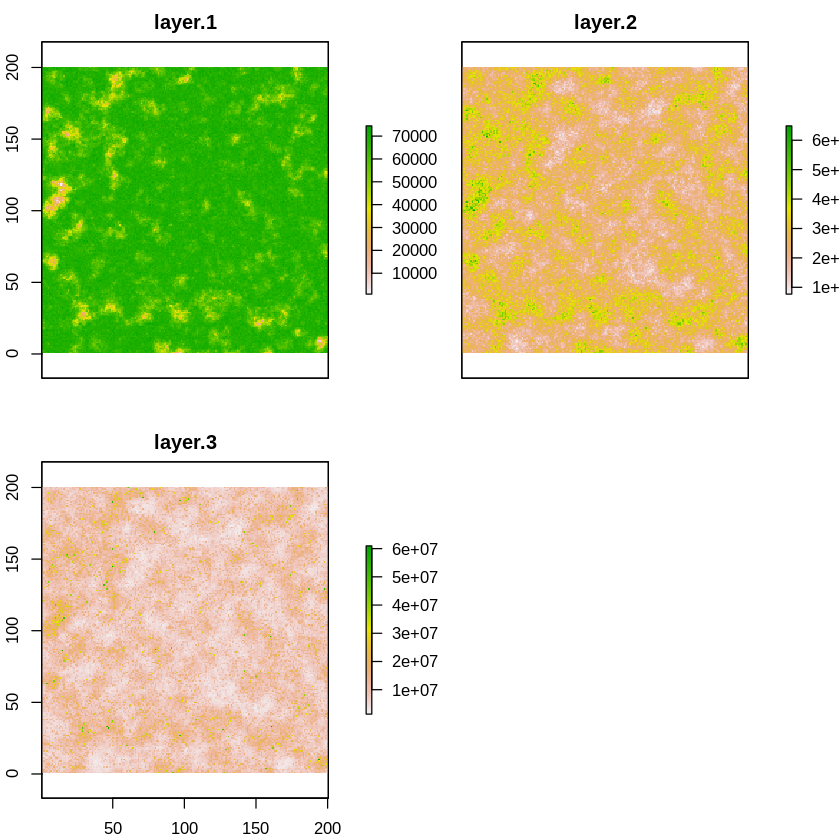

In [3]:
# 1. Define a correlative Funciton with error for 3 predictor variables (no additoinal spatial error)

# predictor 1 formula   p1= 2*rs1 + 10.5*rs1^2 - 0.05*rs1^3 +error(normal)
# predictor 2 formula   p2 = 5*ln(rs1) + rs1^2 + error2(poisson)
# predictor 3 formula   p3= 2*(rs1)^3 + error3 (normal)

#'function to create predictor variables given a raster template, error term, and error type
#'@param tmplateRs = template raster
#'@param eTerm = the amount of error
#'@param errorType = the type of error
#'@param return = a raster surface with error
createPredSurface = function(tmplateRs, eTerm = "", errorType = 'poisson') {
    clms = ncol(tmplateRs)
    rws = nrow(tmplateRs)
    errRs = raster(tmplateRs)
    if (errorType == 'normal') {
        err = rnorm((rws * clms), 0, eTerm)
    } else if (errorType == 'poisson') {
        err = rpois(tmplateRs[], tmplateRs[])*0.5 + 0.00001
    } else if (errorType == 'proportional') {
        err = tmplateRs[] * rnorm((rws * clms), eTerm, eTerm * 0.6)
    } else {
        err = rnorm((rws * clms), 0, eTerm)
    }
    errRs[] = err
    return(errRs)
}

# 2. create error surfaces
errRs1 = createPredSurface(rs1, 1500, 'normal')
errRs2 = createPredSurface(rs1)^2*40
errRs3 = createPredSurface(rs1, 0.70, 'proportional') ^3

# 3. create predictor rasters surfaces
pred1 = 2*rs1 + 10.5*rs1^2 + -0.05*rs1^3 + errRs1
pred2 = 5*log(rs1) + rs1^2 + errRs2
pred3 = 2*(rs1)^3 + errRs3

#set null values to zero (due to forumula)
pred1[is.na(pred1)] = 0
pred2[is.na(pred2)] = 0
pred3[is.na(pred3)] = 0

# 4. Plot raster surfaces
pred = stack(pred1,pred2,pred3)
print(pred)
plot(pred)


# Randomly sample our raster surfaces (response and predictor)


1.   Create a random sample of 400 locations
2.   Use sample location coordinates to extract raster values
3.   Turn those extracted values into a data frame
4.   Split that data frame into a training (dft,n=200) and validation (dfv,n=200) datasets
4.   View data and relationship for the training sample



,resp,pred1,pred2,pred3
,<dbl>,<dbl>,<dbl>,<dbl>
231,158.8788,63739.69,324557.9,8020592
75,184.3876,48204.53,430034.9,18539086
227,141.1564,67855.66,254039.9,5625745
3,139.3505,68998.14,207133.3,7284207
100,158.3943,67911.01,250114.1,7947625
274,154.6558,69279.44,279943.7,7594457


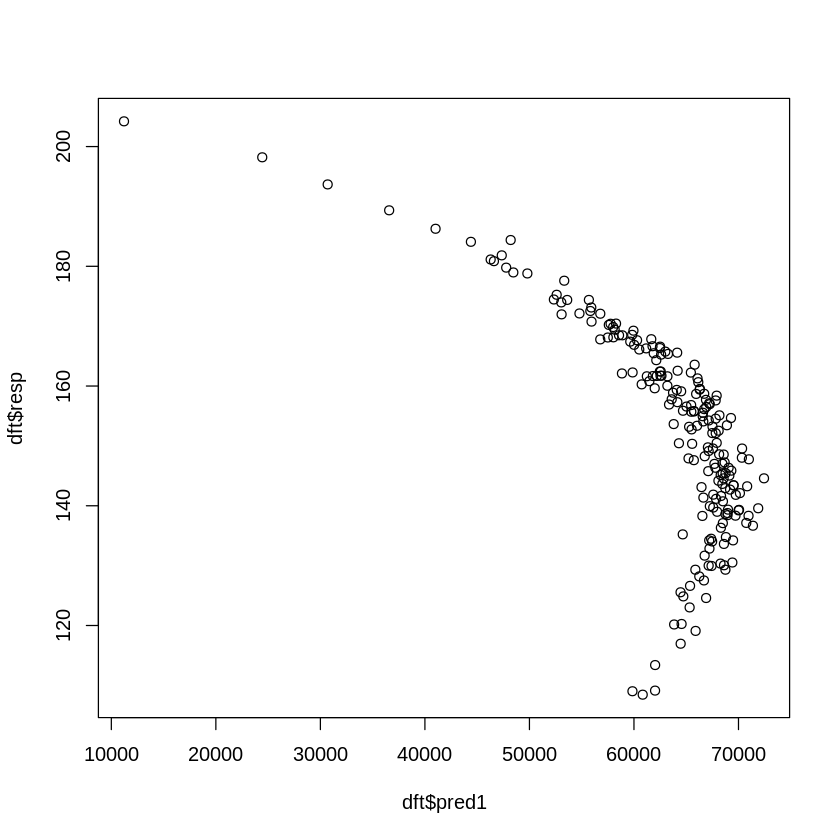

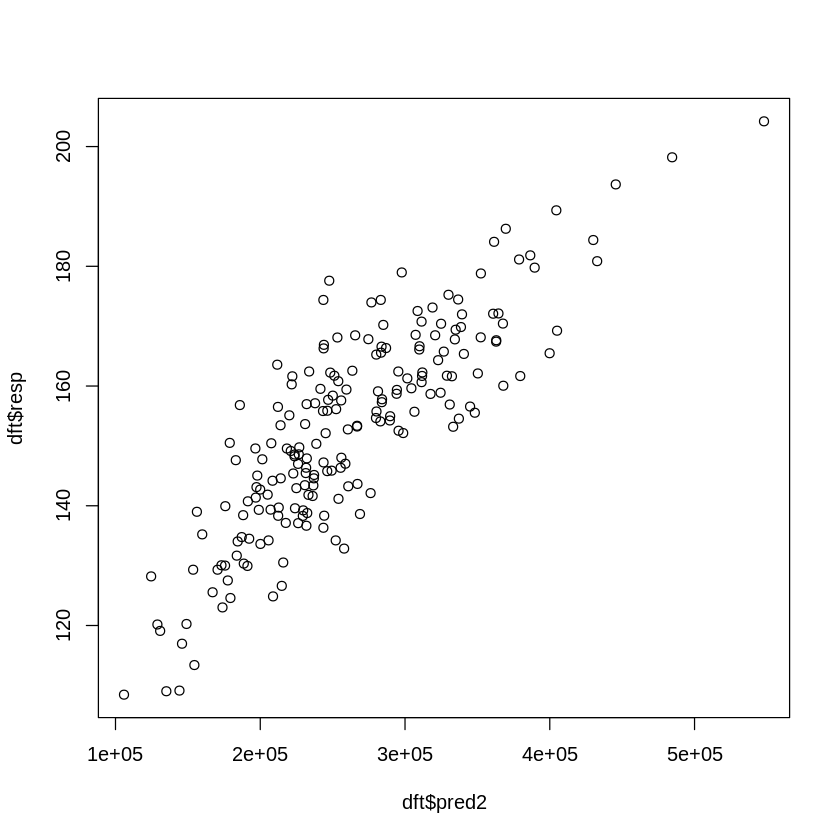

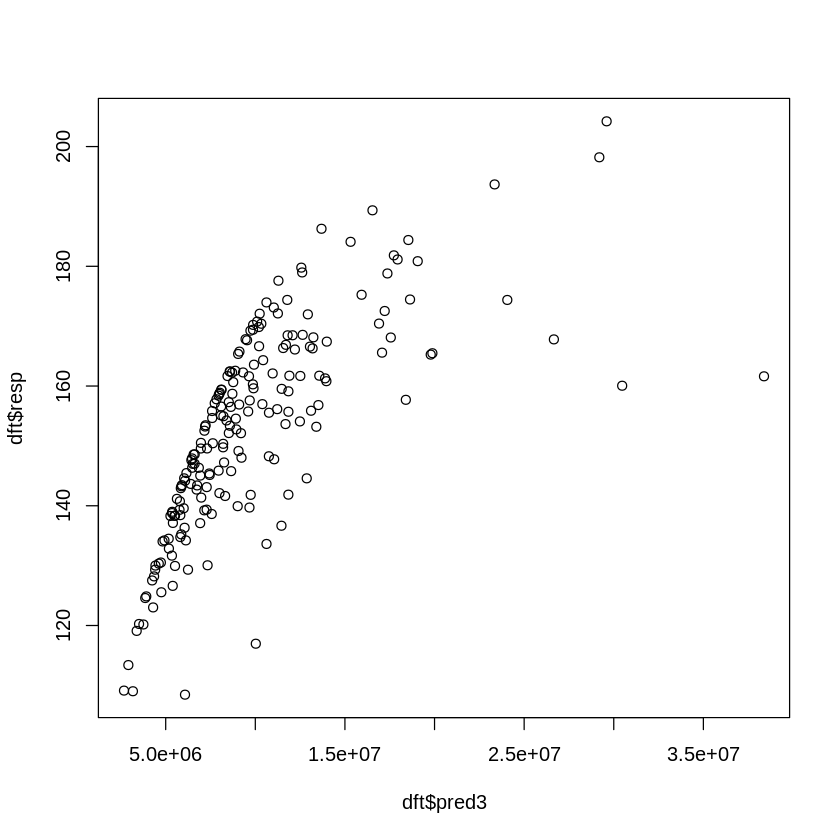

In [4]:
# 1. Create a random sample of 400 locations
obsCnt = ncell(rs1)
rspVls = sample(seq(obsCnt),400)

# 2. Use the coordinates of that sample location to extract raster values
# 3. Turn those extracted values into a data frame
dfall = data.frame(resp=rs1[][rspVls],pred1=pred1[][rspVls],pred2=pred2[][rspVls],pred3=pred3[][rspVls])

# 4. Split that data frame into a training (dft,n=200) and validation (dfv,n=200) datasets
sIndex = sample(nrow(dfall), 200)
dft = dfall[sIndex,]
dfv = dfall[-sIndex,]

# 5. View data and relationship for the training sample
head(dft)
plot(dft$pred1,dft$resp)
plot(dft$pred2,dft$resp)
plot(dft$pred3,dft$resp)



# Now that we have a dataset with response and predictors, we can use mgcv to select predictors and generate our EGAM.


1.   Create an iterative function to select predictor variables.
2.   Get significant variabels using getGamSigFldNames adn the dataframe (dft) and look at model fit statistics and visualization plots.
3.   Create ensemble of GAMS (EGAMS) function.
4.   Use the CreateEnsembelGam function to make a EGAM with our data frame (dft) and our significant predictor variables (predVar).
5.   Report RMSE and graph observed vs predicted values for validation dataset (dfv) with a grey one to one line, smoothed loess line, and red dashed 95% confidence intervals and the approximate 95% prediction intervals (green dashed lines).
6.   Apply our model to our predictor raster surfaces to create a new surface with mean and standard error estimates.
7.   Compare the response surface to the predicted surface and plot the results.



# 1. Create an iterative function to select predictor variables. 
> ### getGamSigFldNames(indata, resp, pred, alpha = 0.05, fam = gaussian(), improveby = 0)
> note, running this code will load functions into memory but will not produce output

In [5]:
#' Get best GAM using all data in the data framee
#' @param indata = input data frame
#' @param resp = response field name
#' @param pred = vector of potential predictor variables
#' @param alpha = significance level used to select variables (0.05)
#' @param fam = family distribution (gaussian())
#' @param improveby = the amount needed to improve % deviance explained to include a predictor variable (0)
#' @return = list of significant variable vector and GAM
getGamSigFldNames<-function(indata, resp, pred, alpha = 0.05, fam = gaussian(), improveby = 0) {
    nlp = 1
    if (fam$family == "multinom") {
        nlp = fam$nlp
    }
    sigVar <- c()
    pdiv <- 0
    pr2 <- 0
    for (i in seq(length(pred))) {
        vars <- c(sigVar, pred[i])
        fm <- getFormula(resp,vars,nlp) 
        md <- gam(fm, data = indata, family = fam)
        smry <- summary(md)
        div <- smry$dev.expl
        if (div > (pdiv + improveby)) {
            print(paste("Adding variable", pred[i], collapse = " "))
            pvalues <- c(smry$s.pv)
            sigVar <- c()
            nonSigVar <- c()
            for (j in seq(length(vars))) {
                pv <- getSmallestPvalue(j,pvalues,nlp)
                if (pv <= alpha) {
                    sigVar <- c(sigVar, vars[j])
                }
                else {
                    nonSigVar <- c(nonSigVar, vars[j])
                }
            }
            if (length(nonSigVar) > 0) {
                for (k in nonSigVar) {
                    print(paste(cat("\t"), "Rechecking non significant variables", k, collapse = " "))
                    vars2 <- c(sigVar, k)
                    cfm <- getFormula(resp,vars2,nlp)
                    nmd <- gam(cfm, data = indata, family = fam)
                    nsmry <- summary(nmd)
                    ndiv <- nsmry$dev.expl
                    pvalues <- c(nsmry$s.pv)
                    cpvalue <- getSmallestPvalue(length(vars2),pvalues,nlp)
                    if (cpvalue <= alpha) {
                        sigVar <- c(sigVar, k)
                        print(paste(cat("\t"), "adding", k, "back to the model", collapse = " "))
                    }
                }
                ndiv <- pdiv
                if (length(sigVar) > 0) {
                    cfm <- getFormula(resp,sigVar,nlp) #as.formula(paste(resp, " ~ ", paste("s(", sigVar, ")", collapse = " + ")))
                    nmd <- gam(cfm, data = indata, family = fam)
                    nsmry <- summary(nmd)
                    ndiv <- nsmry$dev.expl
                }
                if (ndiv < (pdiv + improveby)) {
                    print(paste(cat("\t"), "No improvement. Changing sig variables back to what they previously were"))
                    sigVar <- vars[1:length(vars) - 1]
                }
                else {
                    pdiv <- ndiv
                }
            }
            else {
                pdiv <- div
            }
            print(paste(cat("\t"), "sig var for iter ", i, "(%Div = ",pdiv, "):", paste(sigVar, collapse = " ")))
        }
    }
    print(paste(cat("\t"), "Removing variables that do not meet significance level",sep = ""))
    fmd <- removeLeastSignificantVar(resp, indata, sigVar, fam, alpha, nlp)
    while (!is.null(fmd[[1]])) {
        sigVar = fmd[[1]]
        fmd = removeLeastSignificantVar(resp, indata, sigVar, fam, alpha, nlp)
    }
    return(list(sigVar,fmd[[2]]))
}

#  Used to remove the least significant variable and make a new GAM.
#' @param resp = response field name 
#' @param indata = input data frame
#' @param sigVar = vector of significant variables
#' @param fam = family distribution (gaussian())
#' @param alpha = significance level used to select variables (0.05)
#' @param nlp = the number of linear predictors
#' @return = list of significant variable vector and GAM
removeLeastSignificantVar <- function(resp, indata, sigVar, fam, alpha, nlp) {
    cfm <- getFormula(resp, sigVar, nlp)
    nmd <- gam(cfm, data = indata, family = fam)
    nsmry <- summary(nmd)
    pvalues <- c(nsmry$s.pv)
    fVar <- c()
    malpha = NULL
    nSigVar = NULL
    for (i in 1:length(sigVar)) {
        tpv <- getSmallestPvalue(i, pvalues, nlp)
        fVar <- c(fVar,tpv)
    }
    fVarT = fVar > alpha
    if (sum(fVarT) > 0) {
        malpha = max(fVar)
    }
    if (!is.null(malpha)) {
        mVarIndex = which(fVar == malpha)
        nSigVar = sigVar[-mVarIndex]
    }
    
    return(list(nSigVar,nmd))
}

#  Used to get the preditor with the smallest p value.
#' @param vlIndex = index of variable
#' @param pvalues = vector of pvalues
#' @param nlp = number of linear predictors
#' @return = smallest pvalue
getSmallestPvalue <- function(vlIndex, pvalues, nlp) {
    mVl = pvalues[vlIndex]
    if (nlp > 1) {
        cVec <- vector(mode = "numeric", length = nlp)
        cnt = 1
        for (i in seq(vlIndex, length(pvalues), length(pvalues)/nlp)) {
            pvl = pvalues[[i]]
            cVec[cnt] = pvl
            cnt = cnt + 1
        }
        mVl = min(cVec)
    }
    return(mVl)
}

#  Used to create a formula for the mgcv routine.
#' @param rVar = response variable
#' @param pVars = vector of predictor variables
#' @param numlp = number of linear predictors
#' @return = formula
getFormula <- function(rVar, pVars, numlp) {
    fm=as.formula(paste(rVar, " ~ ", paste("s(", pVars, ")", collapse = " + ")))
    if (numlp > 1) {
        fml = list(length = numlp)
        fml[[1]] = fm
        for (f in 2:numlp) {
            fml[[f]] = as.formula(paste("~ ", paste("s(", pVars, ")", collapse = " + ")))
        }
        fm <- fml
    }
    return(fm)
}


# 2. Get significant variabels using getGamSigFldNames adn the dataframe (dft) and look at model fit statistics and visualization plots.
- response = "resp"
- pred = c("pred1", "pred2", "pred3")
- data frame = dft


[1] "Adding variable pred1"
	[1] " sig var for iter  1 (%Div =  0.535827195653201 ): pred1"
[1] "Adding variable pred2"
	[1] " sig var for iter  2 (%Div =  0.85779019300139 ): pred1 pred2"
[1] "Adding variable pred3"
	[1] " sig var for iter  3 (%Div =  0.91022531624865 ): pred1 pred2 pred3"
	[1] "Removing variables that do not meet significance level"
[1] "pred1" "pred2" "pred3"



Family: gaussian 
Link function: identity 

Formula:
resp ~ s(pred1) + s(pred2) + s(pred3)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 152.8193     0.3745   408.1   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
           edf Ref.df     F p-value    
s(pred1) 2.014  2.520 48.39  <2e-16 ***
s(pred2) 4.314  5.375 24.04  <2e-16 ***
s(pred3) 5.789  6.917 16.60  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.904   Deviance explained =   91%
GCV = 30.019  Scale est. = 28.05     n = 200

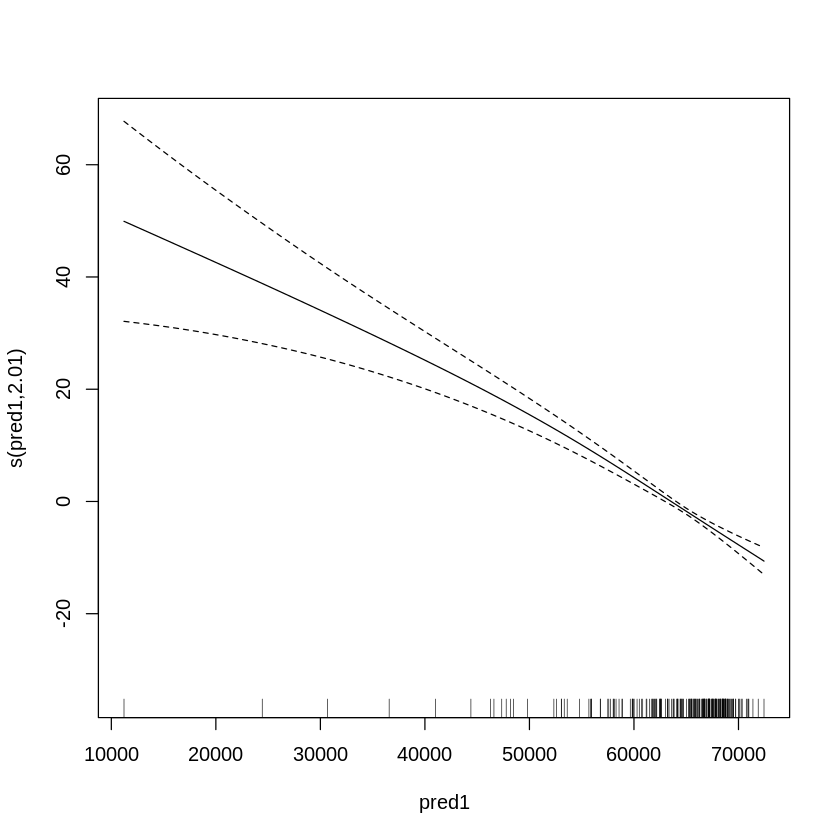

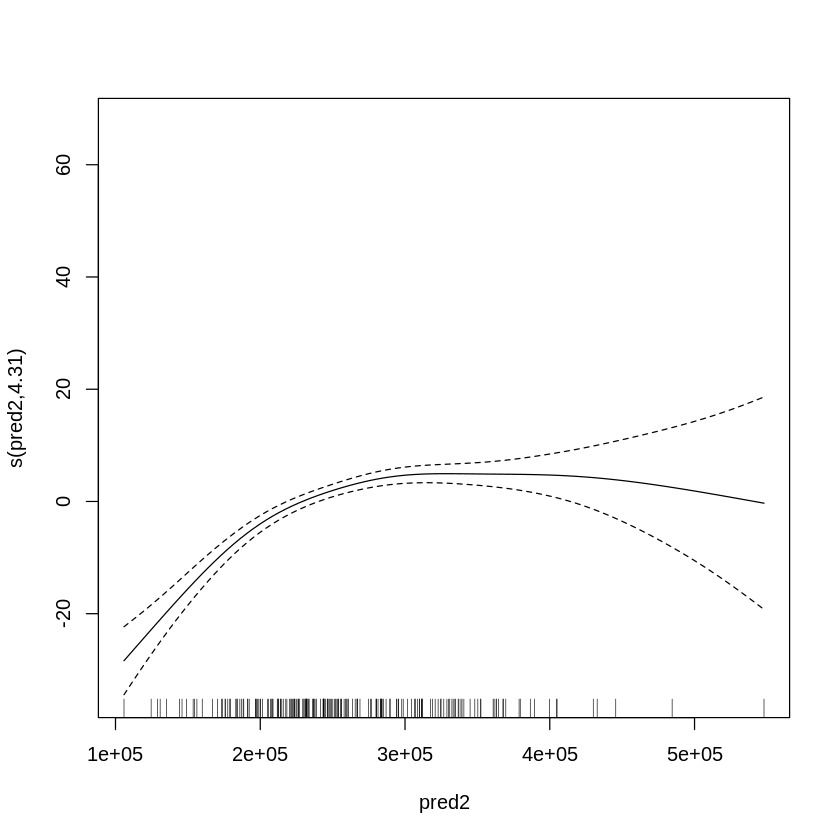

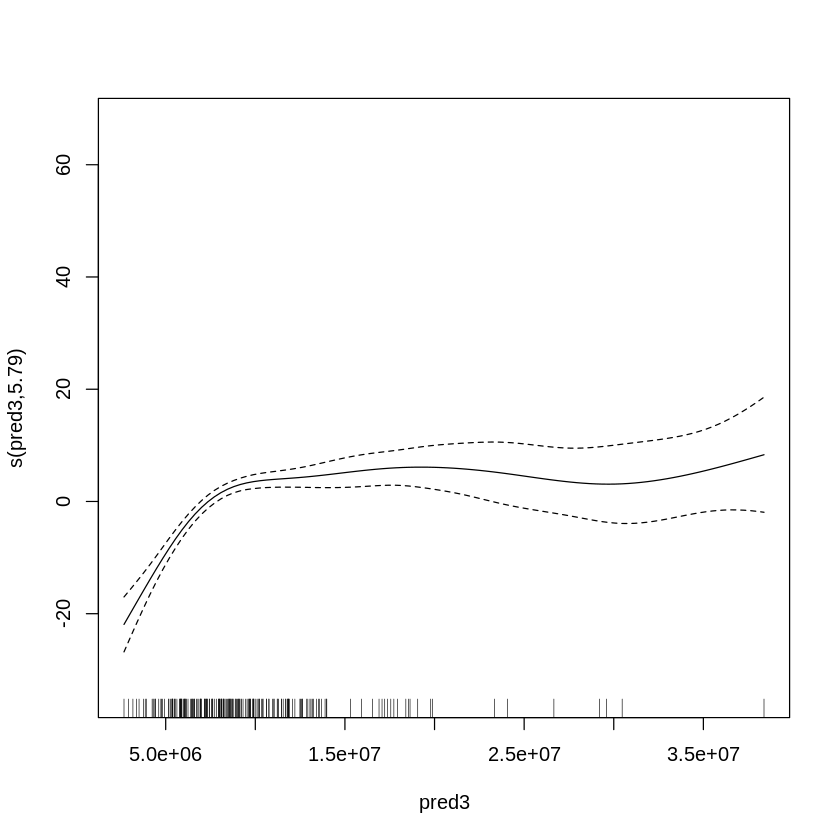

In [6]:
outVar=getGamSigFldNames(dft,"resp",c("pred1","pred2","pred3"))
predVar=outVar[[1]]
gamMdl=outVar[[2]]
print(predVar)
summary(gamMdl)
plot(gamMdl)



# 3. Create ensemble of GAMS (EGAMS) function 
> ### createEnsembleGam(frm, df, fam, nmdl, ptrain, kfact)
> ### predictEnsembleGam(bGamMdl, df)
> note, running this code will load functions into memory but will not produce output

1.   Create a generic ensemble function
2.   Create 3 helper functions that get called within the createEnembleGam function
3.   Create a EGAM prediction function



In [7]:
#1. Create a generic ensemble function

#' This function creates an EGAM
#' @param frm = formula
#' @param df = dataframe
#' @param fam = family default = gaussian()
#' @param nmdl = number of models default = 50
#' @param ptrain = percent of data used to train the model default = 0.75
#' @param kfact = keep factor for models: used to select models that have a similar RMSE training and testing datasets
#' @return list of gam models, oob, and training rmse
createEnsembleGam <- function(frm, df, fam = gaussian(), nmdl = 50, ptrain = 0.75, kfact = 20) {
    mdlV = list(length = nmdl)
    rmseV = vector(mode = "double", length = nmdl)
    rmseT = vector(mode = "double", length = nmdl)
    n = round(ptrain * nrow(df))
    mdlCnt = 0
    while (mdlCnt < nmdl) {
        sIndex = sample(nrow(df), n)
        tdf = df[sIndex,]
        vdf = df[-sIndex,]
        try({
            mdl = gam(frm, family = fam, data = tdf)

            pvlV = getPredictedValues(mdl, vdf) 
            ovlV = getResponseValues(vdf, mdl) 
            t_rmseV = getErrorEstimate(pvlV, ovlV, mdl) 

            pvlT = getPredictedValues(mdl, tdf) 
            ovlT = getResponseValues(tdf, mdl) 
            t_rmseT = getErrorEstimate(pvlT, ovlT, mdl)

            if (t_rmseV <= (t_rmseT * kfact)) {
                mdlCnt = mdlCnt + 1
                mdlV[[mdlCnt]] = mdl
                rmseV[mdlCnt] = t_rmseV
                rmseT[mdlCnt] = t_rmseT
            }
        }, silent = TRUE)
    }
    return(list(mdlV, rmseV, rmseT))
}

# 2. Create 3 helper functions that get called within the createEnembleGam function

#' Gets the predicted values from the model
#' md = gam model
#' df = dataframe
#' t = type of prediction (default = "response")
getPredictedValues <- function(md, df, t = "response") {
    pVls = predict(md, newdata = df, type = t)
    fm = md$family
    if (fm$family == "multinom") {
        pVls <- apply(pVls, 1, function(x) which(max(x) == x)[1]) - 1
    }
    if (fm$family == "binomial") {
        pVls <- as.integer(pVls > 0.5)
    }
    return(pVls)
}

#' Gets the response values from a GAM model given a dataframe
#' df = dataframe
#' md = GAM
getResponseValues <- function(df, md) {
    fm = md$family
    f = md$formula
    if (fm$family == "multinom") {
        f = f[[1]]
    }
    return(df[all.vars(f)[1]][[1]])
}

#' Gets error estimates from a GAM
#' p = predicted values 
#' o = observed values
#' md = GAM
getErrorEstimate <- function(p, o, md) {
    fm = md$family
    outVl = NULL
    if (fm$family == "multinom" | fm$family == "binomial") {
        outVl = 1 - sum(p == o) / length(p)
    }
    else {
        outVl = sqrt(mean((p - o) ^ 2))
    }
    return(outVl)
}

# 3. Create a EGAM prediction function

#' Predict EGAM model values
#' @param bGamMdl = list of models
#' @param df = new data dataframe
#' @return = vector of mean predictions and standard errors
predictEnsembleGam <- function(bGamMdl, df) {
    fm = bGamMdl[[1]]$family
    m = NULL
    s = NULL
    mdls = length(bGamMdl)
    n = nrow(df)
    if (fm$family == "multinom") {
        nlp = fm$nlp
        sm = matrix(rep(0, n * (nlp + 1)), nrow = n, ncol = nlp + 1)
        s2m = sm
        for (i in seq(mdls)) {
            mdl = bGamMdl[[i]]
            p = predict(mdl, df, type = "response")
            sm = sm + p
            s2m = s2m + p ^ 2
        }
        m = sm / mdls
        s = sqrt((s2m - ((sm ^ 2) / mdls)) / (mdls - 1))
        return(cbind(m, s))

    }
    else {
        sV = vector(mode = "double", length = n)
        s2V = vector(mode = "double", length = n)
        for (i in seq(mdls)) {
            mdl = bGamMdl[[i]]
            p = predict(mdl, df, type = "response")
            sV = sV + p
            s2V = s2V + p ^ 2
        }
        m = sV / mdls
        s = sqrt((s2V - ((sV ^ 2) / mdls)) / (mdls - 1))
        return(cbind(m, s))
    }

}

# 4. Use the CreateEnsembelGam function to make a EGAM with our data frame (dft) and our significant predictor variables (predVar).


In [8]:
frm1=getFormula("resp",predVar,1)
egamOut = createEnsembleGam(frm1,dft,nmdl=50,ptrain=0.7,kfact=30)
egam=egamOut[[1]]
trainError=egamOut[[3]]
testError=egamOut[[2]]
print(paste("Training RMSE = ",mean(trainError),sep=""))
print(paste("Testing RMSE = ", mean(testError), sep=""))

[1] "Training RMSE = 4.99721332468895"
[1] "Testing RMSE = 5.85101366049992"


# 5. Report RMSE and graph observed vs predicted values for validation dataset (dfv) with a grey one to one line, smoothed loess line, and red dashed 95% confidence intervals and the approximate 95% prediction intervals (green dashed lines)

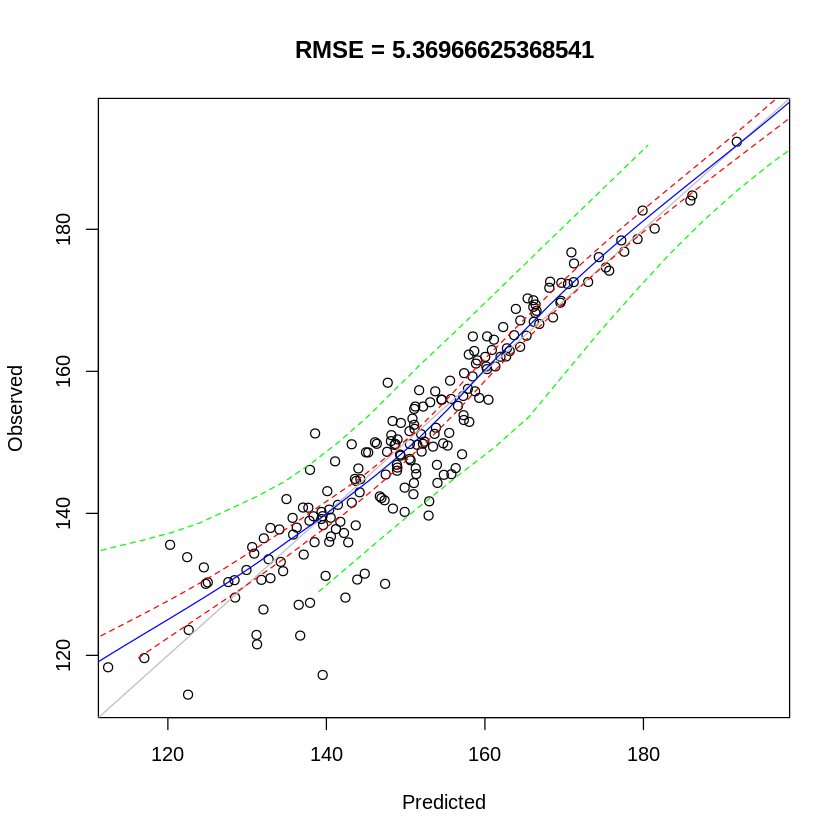

In [9]:
vls = data.frame(predictEnsembleGam(egam,dfv))
rmse=sqrt(mean((dfv$resp-vls$m)^2))
lims = c(min(dfv$resp),max(dfv$resp))
plot(vls$m,dfv$resp,xlim=lims, ylim=lims, xlab="Predicted", ylab="Observed", main=paste("RMSE = ", rmse, sep=""))
abline(0,1,col="grey",lwd=1)
lb = vls$m-(1.96*vls$s)
ub = vls$m+(1.96*vls$s)
plb = vls$m-(vls$s*sqrt(50)*1.96)
pub = vls$m+(vls$s*sqrt(50)*1.96)
lines(loess.smooth(vls$m,dfv$resp), col="blue",lwd=1)
lines(loess.smooth(lb,dfv$resp),col="red",lty=2,lwd=1)
lines(loess.smooth(ub,dfv$resp),col="red",lty=2,lwd=1)
lines(loess.smooth(plb,dfv$resp),col="green",lty=2,lwd=1)
lines(loess.smooth(pub,dfv$resp),col="green",lty=2,lwd=1)

# 6. Apply our model to our predictor raster surfaces to create a new surface with mean and standard error estimates


1.   Create a raster stack of predictors and rename the predictor raster bands to pred1, pred2, pred3  
2.   Run the EGAM prediction function in parallel
3.   Plot the results (mean and standard error estimates)



  |======================================================================| 100%



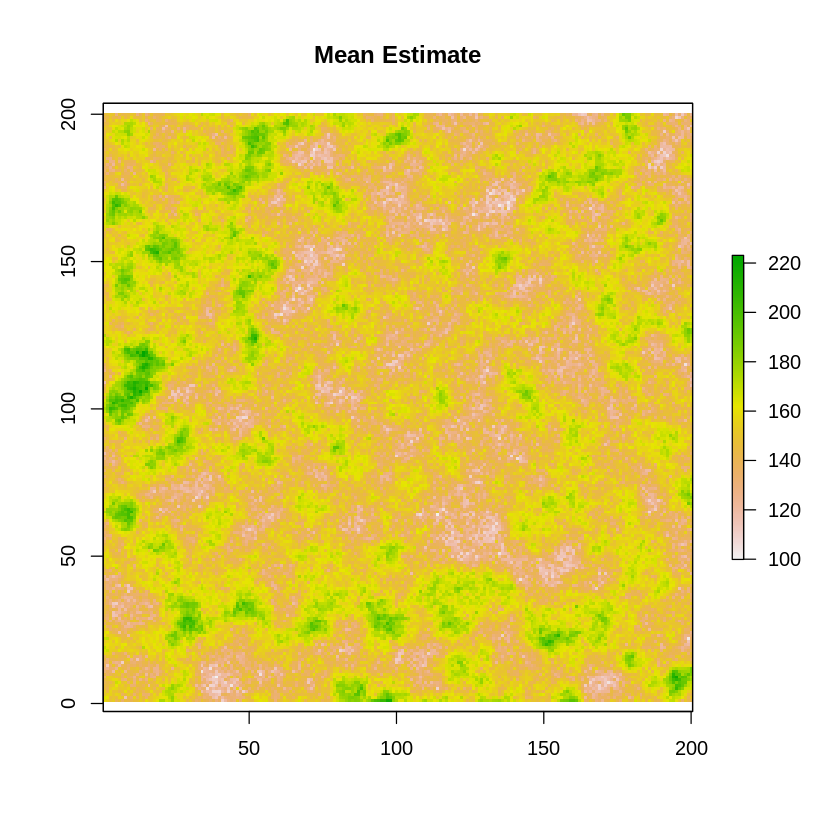

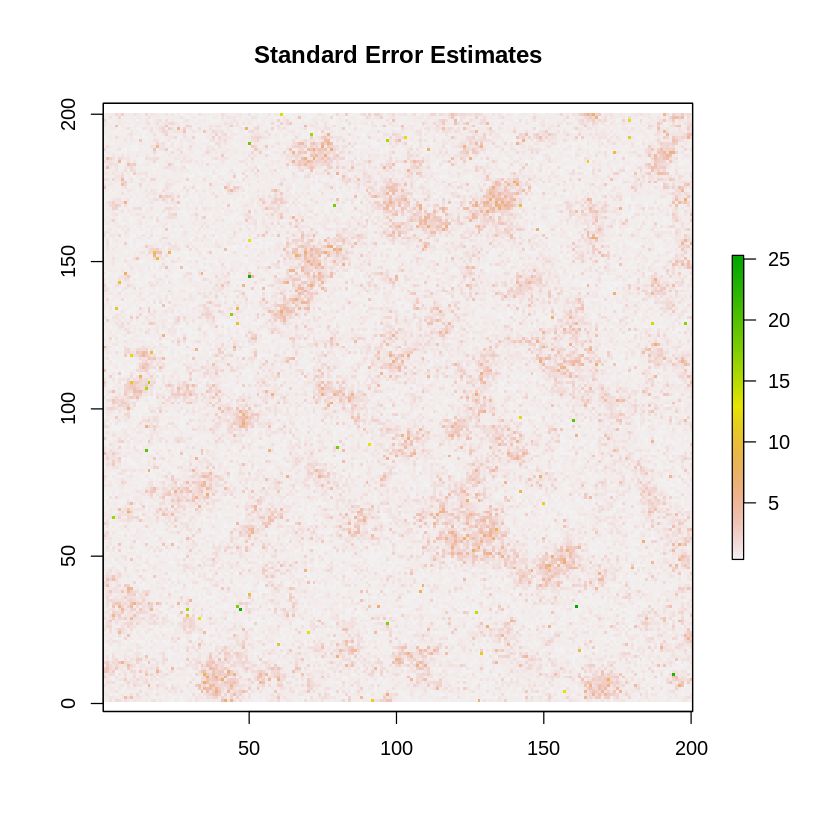

In [10]:
library(parallel)
# 1. Create a raster stack of predictors and rename the predictor raster bands to pred1, pred2, pred3
predRs = stack(pred1,pred2,pred3)
names(predRs) = c("pred1","pred2","pred3")

# 2. Run the EGAM prediction function in parallel
beginCluster(2)
baaRs = clusterR(predRs, predict, args = list(model = egam, fun = predictEnsembleGam, index = 1:2), verbose = TRUE, datatype = "FLT4S", NAFlag = -9999, progress = 'text')
endCluster()

# 3. Plot the results (mean and standard error estimates)
plot(baaRs[[1]],main="Mean Estimate")
plot(baaRs[[2]], main = "Standard Error Estimates")






# 7. Compare the response surface to the predicted surface and plot the results.

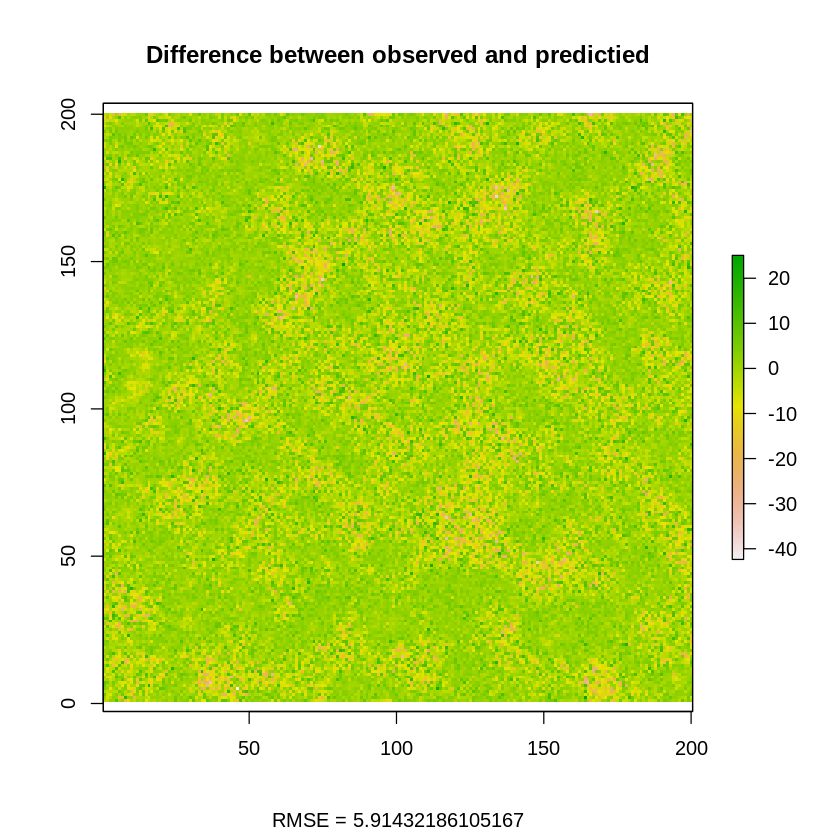

In [11]:
diff = rs1-baaRs[[1]]
diffSq = diff^2
mse=cellStats(diffSq,"mean")
rmse=sqrt(mse)
plot(diff, main="Difference between observed and predictied", sub=paste("RMSE = ",rmse,sep=""))

# This ends the EGAM example. 